# Imports

In [4]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

%reload_ext autoreload
%autoreload 2
#%matplotlib notebook
%matplotlib inline

from typing import List, Callable, Dict

import sys
import os

#https://github.com/FAU-DLM/wsi_processing_pipeline
sys.path.append("../")
sys.path.append("../wsi_processing_pipeline/")
sys.path.append("../wsi_processing_pipeline/tile_extraction")
sys.path.append("../wsi_processing_pipeline/shared")
import wsi_processing_pipeline
import tile_extraction
import preprocessing
import postprocessing
import shared
from wsi_processing_pipeline.tile_extraction import tiles, util, slide, filter
from wsi_processing_pipeline import shared
from wsi_processing_pipeline.preprocessing import *
import wsi_processing_pipeline.preprocessing.files_getter
import wsi_processing_pipeline.preprocessing.name_getter
from wsi_processing_pipeline.preprocessing.name_getter import NameGetter
from wsi_processing_pipeline.preprocessing.tile_image_block import TileImage, label_tl_image, tile_image, TileTransform
from wsi_processing_pipeline.preprocessing.tile_image_block import show_batch, TileImageBlock
from shared.patient_manager import PatientManager
import shared

sys.path.append('../models-pytorch/pretrained-models.pytorch')
import pretrainedmodels
from pretrainedmodels import *


import fastai
from fastai.vision.all import *
from typing import Dict
import pandas as pd
import numpy as np
import os
import torch
torch.backends.cudnn.benchmark=True
import torchvision
from torchvision.models import *
from torchsummary import summary
from functools import partial, update_wrapper
from tqdm import tqdm_notebook as tqdm
import matplotlib.image as mpimg
import shutil

# to fix python OSError: broken data stream when reading image file
# https://stackoverflow.com/questions/42462431/oserror-broken-data-stream-when-reading-image-file
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import sklearn
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from tqdm.notebook import tqdm

import pathlib
from pathlib import Path
Path.ls = lambda x: [p for p in list(x.iterdir()) if '.ipynb_checkpoints' not in p.name]


from concurrent.futures import as_completed, ProcessPoolExecutor
from tqdm import tqdm

#against DecompressionBombWarning
Image.MAX_IMAGE_PIXELS = 10000000000   

PATH = Path('/home/Deep_Learner/private/datasets/glioblastoma_methylation/')
LABELS = PATH/'labels.xlsx'

METHYLATED_1 = PATH/'methylated'
METHYLATED_2 = PATH/'data2018_19'/'methylated'
NON_METHYLATED_1 = PATH/'non_methylated'
NON_METHYLATED_2 = PATH/'data2018_19'/'non_methylated'



seed = 42
np.random.seed(seed)

In [5]:
import fastai
print(fastai.__version__)

import torchvision, torch
print(torch.__version__)
print(torchvision.__version__)
print(torch.version.cuda)

2.0.15
1.6.0
0.7.0
10.2


# Data

## tile paths

In [6]:
tile_paths=wsi_processing_pipeline.preprocessing.files_getter.FilesGetter().get_dirs_and_files(path=PATH, 
                                                                        get_files=True, 
                                                                        suffix='.png', 
                                                                        recursive=True)

217it [01:28,  2.46it/s]


In [7]:
#tile_paths = random.sample(tile_paths, 3000)

In [8]:
len(tile_paths)

1938980

## check images

In [5]:
def check_image(path):
    try:
        open_image(path)
    except Exception as e:
        return path
        
    return None

In [ ]:
with ProcessPoolExecutor(max_workers=32) as pool:
    with tqdm(total=len(tile_paths)) as progress:
        futures = []

        for p in tile_paths:
            future = pool.submit(check_image, p)
            future.add_done_callback(lambda p: progress.update())
            futures.append(future)

        results = []
        for future in as_completed(futures):
            result = future.result()
            if result is not None:
                results.append(result)

In [ ]:
failed = []
for p in tqdm(tile_paths_1819):
    r = check_image(p)
    if r is not None:
        failed.append(r)

## id and label funcs

In [9]:
labels_df = pd.read_excel(LABELS)

In [10]:
labels_df

,patient_id,case_id,slide_id,methylation_status,Unnamed: 4
0,Schwemmer-Andreas-1974-03-14,N296-08,N296-08-I,0.0,NaN
1,Schwemmer-Andreas-1974-03-14,N296-08,N296-08-II,0.0,NaN
2,Ballmann-Artur-1934-06-04,N320-08,N320-08,0.0,NaN
3,Ballmann-Artur-1934-06-04,N320-08,N320-08,0.0,NaN
4,Brandt-Ernst-1941-07-14,N608-08,N608-08,0.0,NaN
...,...,...,...,...,...
206,Härtl_Kaczinski-Anita-1943-01-13,N1606-18,N1606-18,1.0,NaN
207,Heinrich-Dieter-1961-12-21,N1416-18,N1416-18,1.0,NaN
208,Herold-Walter-1953-11-08,N1393-18,N1393-18,1.0,NaN
209,Novic-Stanislav_Valentinovych-1974-02-23,N1300-18,N1300-18,1.0,NaN


In [11]:
def get_slide_id_from_parent_folder_name(parent_folder_name:str)->str:
    split = parent_folder_name.split(sep='.')
    if((len(split) == 3) or (len(split) == 2 and 'I' in split[1])):
        return f'{split[0]}-{split[1]}'
    elif(len(split) == 2):
        return split[0]#
    elif(len(split) == 1):
        return parent_folder_name
    else:
        assert False

def get_patient_id_from_parent_folder_name(parent_folder_name:str)->str:
    slide_id = get_slide_id_from_parent_folder_name(parent_folder_name)
    return list(labels_df.loc[labels_df['slide_id'] == slide_id]['patient_id'])[0]

def get_patient_id_from_tile_path(tile_path:pathlib.Path)->str:
    slide_id = get_slide_id_from_parent_folder_name(tile_path.parent.name)
    return list(labels_df.loc[labels_df['slide_id'] == slide_id]['patient_id'])[0]

def get_case_id_from_tile_path(tile_path:pathlib.Path)->str:
    slide_id = get_slide_id_from_parent_folder_name(tile_path.parent.name)
    return list(labels_df.loc[labels_df['slide_id'] == slide_id]['case_id'])[0]

def get_slide_id_from_tile_path(tile_path:pathlib.Path)->str:
    return get_slide_id_from_parent_folder_name(tile_path.parent.name)

def get_label_from_tile_path(tile_path:pathlib.Path)->List[int]:
    if('non_methylated' in str(tile_path)):
        return [0]
    if('methylated' in str(tile_path)):
        return [1]
    assert False

## patient manager

In [12]:
patient_manager = PatientManager()

In [13]:
patient_manager.create_from_preextracted_tiles(tile_paths=tile_paths, 
                                               patient_id_getter=get_patient_id_from_tile_path,
                                               case_id_getter=get_case_id_from_tile_path, 
                                               slide_id_getter=get_slide_id_from_tile_path, 
                                               labels_getter=get_label_from_tile_path)

100%|██████████| 1938980/1938980 [28:21<00:00, 1139.57it/s] 


In [14]:
train_size = 0.8
validation_size = 0.2
test_size = 0
patient_manager.split(train_size=train_size, validation_size=validation_size, test_size=test_size, random_state=seed)

In [15]:
class_distribution = patient_manager.get_class_distribution(level=shared.enums.EvaluationLevel.tile, 
                                                            dataset_type=shared.enums.DatasetType.all)

In [16]:
class_distribution

(1938980,
 {0: 1186057, 1: 752923},
 {0: 0.6116911984651724, 1: 0.3883088015348276})

In [17]:
class_distribution_train = patient_manager.get_class_distribution(level=shared.enums.EvaluationLevel.tile, 
                                                            dataset_type=shared.enums.DatasetType.train)

In [18]:
class_distribution_train

(1609872,
 {0: 1028347, 1: 581525},
 {0: 0.6387756293668068, 1: 0.3612243706331932})

In [53]:
class_distribution_valid = patient_manager.get_class_distribution(level=shared.enums.EvaluationLevel.tile, 
                                                            dataset_type=shared.enums.DatasetType.validation)

In [54]:
class_distribution_valid

(329108,
 {0: 157710, 1: 171398},
 {0: 0.4792043949098776, 1: 0.5207956050901223})

##  data block api

In [19]:
import PIL

In [20]:
PIL.Image.open(tile_paths[0]).shape

(272, 272)

In [21]:
final_size = 272
bs = 44

#necessary for exporting the learner as pickle file since lambda functions cannot be pickled
def get_x(tile):
    return tile.tile_path
def get_y(tile):
    return tile.labels

data = fastai.data.block.DataBlock(
        blocks=(ImageBlock, fastai.data.block.MultiCategoryBlock),
        #get_x=lambda x: x.tile_path, 
        #get_y=lambda x: x.labels,
        get_x=get_x, 
        get_y=get_y,
        splitter=fastai.data.transforms.FuncSplitter(lambda x: x.get_dataset_type() == shared.enums.DatasetType.validation),
        item_tfms = fastai.vision.augment.Resize(final_size, method = 'squish'),
        #item_tfms = fastai.vision.augment.RandomResizedCrop(size=final_size),
        batch_tfms=fastai.vision.augment.aug_transforms(flip_vert=True))

dls = data.dataloaders(patient_manager.get_all_tiles(), bs=bs)

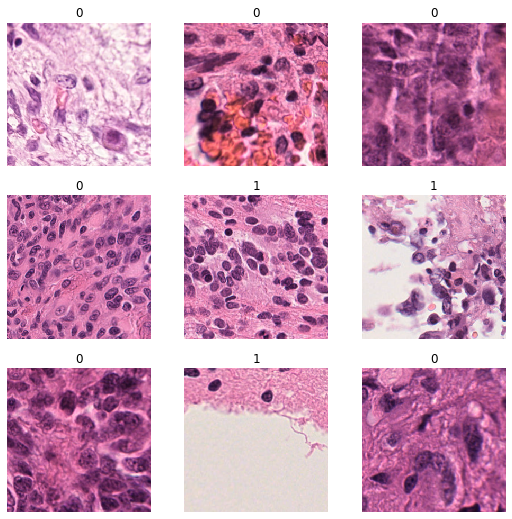

In [24]:
dls.show_batch()

# learner

## n 

In [22]:
n = np.load('n.npy')
print(n)
#m = n+1
m=1
np.save('n.npy', m)
print(m)

1
1


## create

In [23]:
arch = torchvision.models.resnet.resnext101_32x8d

learner = cnn_learner(dls=dls, 
                     arch=arch, 
                     metrics=[fastai.metrics.accuracy_multi],
                     pretrained=True,
                     path=PATH/'models'/f'{n}-{arch.__name__}')

In [24]:
learner.to_fp16()

In [25]:
learner.path

Path('/home/Deep_Learner/private/datasets/glioblastoma_methylation/models/1-resnext101_32x8d')

In [26]:
learner.path.parent.mkdir(exist_ok=True)

In [27]:
learner.path.mkdir(exist_ok=True)

## name

In [28]:
epochs_frozen = 5
epochs_unfrozen = 10

In [29]:
nameBase = f'{n}-{arch.__name__}'
nameBase

'1-resnext101_32x8d'

## train

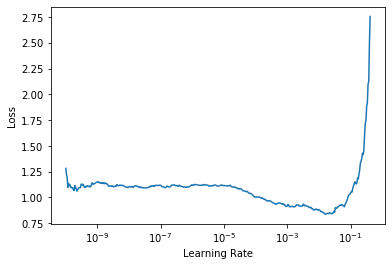

In [35]:
lr_min, lr_steep=learner.lr_find(start_lr=1e-10, end_lr=10, num_it=500)

In [30]:
lr1 = 1e-3

In [31]:
log_head_name = 'log-head.csv'

In [ ]:
learner.fit_one_cycle(n_epoch=epochs_frozen, 
                      lr_max=lr1, 
                      cbs=[CSVLogger(fname=log_head_name), SaveModelCallback(every_epoch=True, fname='head')])

epoch,train_loss,valid_loss,accuracy_multi,time


In [39]:
pd.read_csv(learner.path/log_head_name)

,epoch,train_loss,valid_loss,accuracy_multi,time
0,0,0.152809,2.503081,0.459085,11:02:31
1,1,0.114862,2.567990,0.456508,10:45:28
2,2,0.080179,3.719217,0.430983,11:00:09
3,3,0.085613,3.428276,0.444091,10:44:01
4,4,0.066342,3.480905,0.452004,10:41:26


In [40]:
nameHead = f'{nameBase}-head';nameHead

'1-resnext101_32x8d-head'

In [41]:
learner.save(nameHead)

Path('/home/Deep_Learner/private/datasets/glioblastoma_methylation/models/1-resnext101_32x8d/models/1-resnext101_32x8d-head.pth')

In [42]:
learner.unfreeze()

SuggestedLRs(lr_min=1.1748975339287427e-07, lr_steep=5.248074739938602e-05)

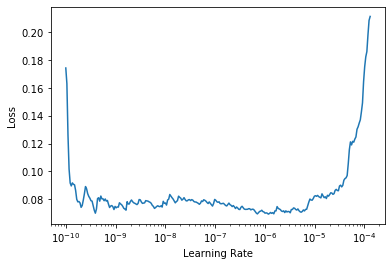

In [44]:
learner.lr_find(start_lr=1e-10, end_lr=10, num_it=500)

In [45]:
lr2 = 3e-8
lr3 = 1e-6

In [46]:
log_complete_name = 'log-complete.csv'

In [ ]:
learner.fit_one_cycle(n_epoch=epochs_unfrozen, 
                      lr_max=[lr2, lr3], 
                      cbs=[CSVLogger(fname=log_complete_name), SaveModelCallback(every_epoch=True, fname='complete')])

epoch,train_loss,valid_loss,accuracy_multi,time


In [50]:
pd.read_csv(learner.path/log_complete_name)

,epoch,train_loss,valid_loss,accuracy_multi,time
0,0,0.067034,3.588033,0.452040,14:34:23
1,1,0.067784,3.523035,0.451087,14:34:57
2,2,0.070181,3.579619,0.455022,14:36:02
3,3,0.067102,3.622834,0.458207,14:35:21
4,4,0.062412,3.569635,0.456236,14:36:12
5,5,0.068384,3.880034,0.451396,14:34:30
6,6,0.063695,3.681809,0.454273,14:36:15
7,7,0.062365,3.536774,0.457707,14:35:41
8,8,0.059704,3.553159,0.457402,14:34:27
9,9,0.068418,3.596486,0.456002,14:32:46


In [51]:
nameComplete = f'{nameBase}-complete'; nameComplete

'1-resnext101_32x8d-complete'

In [52]:
learner.save(nameComplete)

Path('/home/Deep_Learner/private/datasets/glioblastoma_methylation/models/1-resnext101_32x8d/models/1-resnext101_32x8d-complete.pth')

# prediction

In [55]:
from postprocessing.predictor import Predictor

In [56]:
predictor = Predictor(learner=learner, patient_manager=patient_manager)

In [58]:
predictor.predict_on_tiles(prediction_type=shared.enums.PredictionType.preextracted_tiles, 
                          dataset_type=shared.enums.DatasetType.validation,
                          tile_size=final_size, batch_size=bs)

In [59]:
patient_manager.get_classes()

[0, 1]

In [61]:
thresholds = {0:0.5, 1:0.5}
predictor.calculate_predictions_up_to_case_level(dataset_type=shared.enums.DatasetType.validation,
                                                thresholds_tile_level = thresholds,
                                                thresholds_higher_level = thresholds)

# evaluation